## Imports

In [2]:
# notebook imports
import warnings

# Baseline imports 
import pandas as pd
import numpy as np
import re
import seaborn as sns

# Preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# Modeling 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

warnings.filterwarnings("ignore")

## Data Preparation

Firstly, we need to remove useless columns (ids) and drop any rows who have a NaN value in the Bucket column since that is our target variable. We also can convert Bucket to a boolean column for ease of understanding by making a new column marking if a row is in Bucket 1 or not. 

In [4]:
df = pd.read_csv("../data/out/out.csv")
df = df[df["country"] == "China"]
df = df[["text", "Bucket", "SentimentScore"]]
df.head()

,text,Bucket,SentimentScore
0,"Socialist tyrant Maduro starves, tortures his ...",1,2.0
2,"Russia, China, India, Pakistan, North Korea, I...",1,2.0
3,"Ileana Ros-Lehtinen, Ted Yoho Condemn China's ...",1,1.5
5,"BREAKING: In Oval Office meeting today, the Ch...",1,4.5
6,"BREAKING: In Oval Office meeting today, the Ch...",1,4.0


In [5]:
stop_words = set(stopwords.words('english'))

def text_cleaning(text):
    
    text = text.lower()
    text = re.sub('[^A-Za-z0-9\s]', '', text)
    tokens = [x for x in word_tokenize(text) if x not in stop_words]
    reshape_text = " ".join(tokens)
    return reshape_text

def handle_score(score):
    
    if pd.isnull(score):
        return score
    
    score = int(score)
        
    if score > 5.0:
        score = 5.0
    elif score < 1.0:
        score = 1.0
        
    return score

df['text'] = df['text'].apply(text_cleaning)
df['relevant'] = df['Bucket'].apply(lambda bkt: bkt == "1")
df['score'] = df['SentimentScore'].apply(handle_score)

df.drop(columns = ["Bucket", "SentimentScore"], inplace = True, errors = "ignore")
df.reset_index(inplace = True, drop = True)
df.head()

,text,relevant,score
0,socialist tyrant maduro starves tortures peopl...,True,2.0
1,russia china india pakistan north korea iran m...,True,2.0
2,ileana roslehtinen ted yoho condemn chinas tre...,True,1.0
3,breaking oval office meeting today chinese com...,True,4.0
4,breaking oval office meeting today chinese com...,True,4.0


# Model 1:

## Can we determine if a particular tweet is relevant to China or not ? 

We can also determine our x (feature) and y (target) variables early on as well. 

In [4]:
x = df['text']
y = df['relevant']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, shuffle = True)

In [5]:
x_test.shape

(2425,)

In [6]:
dt_classifier = Pipeline([('tfidf', TfidfVectorizer()), ('clf', DecisionTreeClassifier())])
svm_classifier = Pipeline([('tfidf', TfidfVectorizer()), ('svm', SVC())])
knn_classifier = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])

dt_classifier.fit(x_train, y_train)
svm_classifier.fit(x_train, y_train)
knn_classifier.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])

In [36]:
def get_stats(guess, true, mc):
    
    if mc:
        average = 'macro'
    else:
        average = 'binary'
    
    acc = (guess == true).mean()
    precision = precision_score(true, guess, average = average)
    recall = recall_score(true, guess, average = average)
    f1 = (2 * precision * recall) / (precision + recall)
    
    return acc, precision, recall, f1

# dt 
preds_dt = dt_classifier.predict(x_test)
cm_dt = confusion_matrix(y_test, preds_dt)

# svc 
preds_svm = svm_classifier.predict(x_test)
cm_svm = confusion_matrix(y_test, preds_svm)

# knn
preds_knn = knn_classifier.predict(x_test)
cm_knn = confusion_matrix(y_test, preds_knn)

### Results

Let's visualize the classification strength of these models.

Firstly, the `DecisionTreeClassifier()`

<AxesSubplot: >

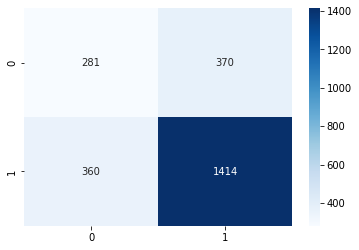

In [8]:
sns.heatmap(cm_dt, cmap = "Blues", annot = True, fmt = "1")

Next, the `SVM()`

<AxesSubplot: >

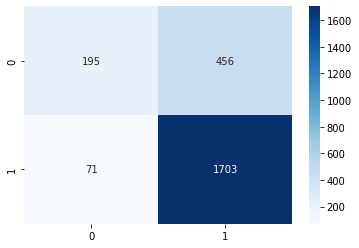

In [9]:
sns.heatmap(cm_svm, cmap = "Blues", annot = True, fmt = "1")

Next, the `KNeighborsClassifier()`

<AxesSubplot: >

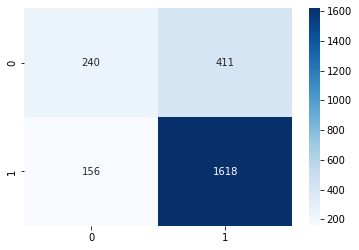

In [10]:
sns.heatmap(cm_knn, cmap = "Blues", annot = True, fmt = "1")

Let's also get the summary statistics from our models: accuracy, precision, & recall.

In [11]:
measures = [get_stats(preds_dt, y_test), get_stats(preds_svm, y_test), get_stats(preds_knn, y_test)]
measures

[(0.6989690721649484,
  0.7926008968609866,
  0.7970687711386697,
  0.7948285553681844),
 (0.7826804123711341,
  0.7887911069939787,
  0.9599774520856821,
  0.8660055936943808),
 (0.7661855670103093,
  0.7974371611631346,
  0.9120631341600902,
  0.8509071785432554)]

### Hyperparameter Tuning

#### 1. Decision Tree Classifier

In [12]:
parameters = {'clf__min_samples_split':[2,3,5,7], 'clf__min_samples_leaf':[2,3,5,7], 'clf__max_depth':[4,5,6,7,8]}
model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', DecisionTreeClassifier())])

tuner = GridSearchCV(model, parameters, verbose = 1)
tuner.fit(x_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', DecisionTreeClassifier())]),
             param_grid={'clf__max_depth': [4, 5, 6, 7, 8],
                         'clf__min_samples_leaf': [2, 3, 5, 7],
                         'clf__min_samples_split': [2, 3, 5, 7]},
             verbose=1)

In [13]:
tuner.best_params_

{'clf__max_depth': 4, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 2}

In [14]:
opt_dt_model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', 
    DecisionTreeClassifier(max_depth= 4, min_samples_leaf = 7, min_samples_split = 2))])

opt_dt_model.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=7))])

In [15]:
new_preds_dt = opt_dt_model.predict(x_test)
get_stats(new_preds_dt, y_test)

(0.734020618556701, 0.7358963643961555, 0.9926719278466741, 0.8452123830093593)

#### 2. Support Vector Classifier

In [17]:
parameters = {
    'clf__C': [0.001, 0.01, 0.1, 1, 3, 5, 10],
    'clf__gamma': ['scale', 'auto'],
    #'clf__kernel': ['linear', 'rbf', 'sigmoid']
}

model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC())])
tuner = GridSearchCV(model, parameters, verbose = 1)
tuner.fit(x_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 3, 5, 10],
                         'clf__gamma': ['scale', 'auto']},
             verbose=1)

In [18]:
tuner.best_params_

{'clf__C': 5, 'clf__gamma': 'scale'}

In [19]:
opt_svm_model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(C = 5, gamma = 'scale'))])
opt_svm_model.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', SVC(C=5))])

In [20]:
new_preds_svm = opt_svm_model.predict(x_test)
get_stats(new_preds_svm, y_test)

(0.7843298969072164,
 0.8055691255495847,
 0.9295377677564826,
 0.8631248364302538)

#### 3. K Nearest Neighbors 

In [26]:
parameters = {
    "clf__n_neighbors": [3, 4, 5, 8, 10, 15, 20],
    "clf__weights": ["uniform", "distance"],
    "clf__algorithm":["auto", "ball_tree", "kd_tree", "brute"]
}

model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])
tuner = GridSearchCV(model, parameters, verbose = 1)
tuner.fit(x_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: 

/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: 

/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: 

/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/gokul/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: 

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'clf__n_neighbors': [3, 4, 5, 8, 10, 15, 20],
                         'clf__weights': ['uniform', 'distance']},
             verbose=1)

In [27]:
tuner.best_params_

{'clf__algorithm': 'auto', 'clf__n_neighbors': 15, 'clf__weights': 'distance'}

In [28]:
opt_knn_model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier(algorithm = 'auto', n_neighbors = 15, weights = 'distance'))])
opt_knn_model.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])

In [29]:
new_preds_knn = opt_knn_model.predict(x_test)
get_stats(new_preds_knn, y_test)

(0.7731958762886598,
 0.7886792452830189,
 0.9425028184892897,
 0.8587570621468927)

# Model 2:

## Can we determine the positive / negative sentiment of a Tweet? 

In [6]:
sub = df.dropna()
sub = sub[['text', 'score']]
sub.reset_index(drop = True, inplace = True)
sub.head()

,text,score
0,socialist tyrant maduro starves tortures peopl...,2.0
1,russia china india pakistan north korea iran m...,2.0
2,ileana roslehtinen ted yoho condemn chinas tre...,1.0
3,breaking oval office meeting today chinese com...,4.0
4,breaking oval office meeting today chinese com...,4.0


In [7]:
x_train, x_test, y_train, y_test = train_test_split(sub["text"], sub["score"], test_size = 0.2)

In [8]:
knn = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsRegressor())])
knn.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', KNeighborsRegressor())])

In [10]:
from sklearn.metrics import mean_squared_error
predicts = knn.predict(x_test)
mse_untuned = mean_squared_error(predicts, y_test)
mse_untuned

0.3592461197339246

In [11]:
parameters = {
    "clf__n_neighbors": [3, 4, 5, 8, 10, 15, 20],
    "clf__weights": ["uniform", "distance"],
    "clf__algorithm":["auto", "ball_tree", "kd_tree", "brute"]
}

model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsRegressor())])
tuner = GridSearchCV(model, parameters, verbose = 1)
tuner.fit(x_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', KNeighborsRegressor())]),
             param_grid={'clf__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'clf__n_neighbors': [3, 4, 5, 8, 10, 15, 20],
                         'clf__weights': ['uniform', 'distance']},
             verbose=1)

In [12]:
tuner.best_params_

{'clf__algorithm': 'auto', 'clf__n_neighbors': 20, 'clf__weights': 'distance'}

In [13]:
opt_knn_model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier(algorithm = 'auto', n_neighbors = 20, weights = 'distance'))])
opt_knn_model.fit(x_train, y_train)
new_predicts = opt_knn_model.predict(x_test)
mse_tuned = mean_squared_error(new_predicts, y_test)
mse_untuned

0.3592461197339246